In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.image as mpimg

#test
from skimage.io import imread
from skimage import data_dir
from skimage.transform import radon, resize, rescale

from skimage.draw import (line, polygon, circle,
                          circle_perimeter,
                          ellipse, ellipse_perimeter,
                          bezier_curve)


In [13]:
#algorytm Bresenhama https://pl.wikipedia.org/wiki/Algorytm_Bresenhama#Implementacja
def get_line(start, end):
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    #print(points)
    return points

In [10]:
def filtr_splotowy(tablica, maska):
    a = len(tablica)
    b = len(maska)
    res = np.zeros(a)
    for i in range(a):
        if i < (b-1)/2 or i > a-(b+1)/2:
            res[i] = tablica[i]
        else:
            suma = 0
            start = int(i - (b-1)/2)
            for j in range(b):
                suma += tablica[start+j]*maska[j]
            res[i] = suma
    return res

In [4]:
def draw_line(img, line):
    for p in line:
        img[p[1]][p[0]] = 0.7

In [5]:
#zwraca pozycję na okręgu w układzie gdzie lewy górny róg to 0,0, a kąt 0 to lewy punkt tego okręgu
def pos_circle(diameter, angle):
    diameter -= 1
    angle = angle % 360
    y = math.sin(0.0174533*angle)
    x = math.cos(0.0174533*angle)
    return [int(x*0.5*diameter+0.5*diameter), int(y*0.5*diameter+0.5*diameter)]

In [6]:
def put_circle(img, pos, size, perimeter=False):
    if perimeter==False:
        rr, cc = circle(int(pos[1]), int(pos[0]), int(size), shape=img.shape)
        img[rr, cc] = 0.0
    else:
        rr, cc = circle_perimeter(int(pos[1]), int(pos[0]), int(size), shape=img.shape)
        img[rr, cc] = 0.0
        

In [7]:
def uklad(diameter, angle, LICZBA, ROZWARTOSC, sinogram, pixels, img, draw=False):
    if sinogram is None:
        sinogram = np.zeros(LICZBA)
        pixels = [0  for y in range(LICZBA)]
        
    step = ROZWARTOSC/LICZBA
    start = int(angle + 180)
    if LICZBA%2==0:
        start += int((LICZBA/2)*(step) - step/2)
    else:
        start += ((LICZBA-1)/2)*step

    a = pos_circle(diameter, angle)
    
    for i in range(LICZBA):
        cur = int(start - step*i)
        b = pos_circle(diameter, cur)
        line = get_line(a, b)
        pixels[i] = line
        
        sum = 0
        for v in line:
            sum += img[v]
            
        sum = sum/len(line)
        sinogram[i] = sum
        
        if draw:
            draw_line(img, get_line(a, b))
            put_circle(img, pos_circle(diameter, cur), 3)


In [11]:
results = np.ones([2,2])
def Radon(krok=1.0, liczba=360, rozwartosc=190, maks=360):
    #krok: kąt obrotu czujników dookoła obiektu w jednej itreacji
    #liczba: liczba promieni wjednej iteracji
    #rozwartość: kąt między pierwszym, a ostatnim promieniem w jednej iteracji
    #maks: do jakiego maksymalnego kąta czujniku mają się przesuwać (na tej podstawie obliczana jest liczba iteracji)
    maks
    KROK = krok
    LICZBA = liczba
    ROZWARTOSC = rozwartosc
    START = 0
    LKROKOW = int(maks/KROK)

    img = imread("mri3.jpg", as_gray=True)
    #img = imread(data_dir + "/phantom.png", as_gray=True)
    img = resize(img, (150,150), anti_aliasing=False, mode='constant')


    count = 1
    q = 4
    fig=plt.figure(figsize=(15,10))
    fig.add_subplot(2, q, count)
    count += 1
    plt.imshow(img, vmin=0, vmax=1, interpolation="None", cmap="gray")

    x = img.shape[0]

    #newX = int(math.sqrt(2)*x)
    newX = int(1.5*x)
    newImg = np.zeros([newX, newX])

    offset1 = int(0.5*newX-0.5*x)
    offset2 = offset1 + x;

    newImg[offset1:offset2, offset1:offset2] = img

    put_circle(newImg, [newX/2, newX/2], newX/2, True)

    ukladImg = np.array(newImg)
    uklad(newX, START, LICZBA, ROZWARTOSC, None, None, ukladImg, True)

    fig.add_subplot(2,q,count)
    count+=1
    plt.imshow(ukladImg, vmin=0, vmax=1, interpolation="bilinear", cmap="gray")

    
    sinogram = np.zeros([LKROKOW, LICZBA])
    #pixels = np.zeros([LICZBA, LKROKOW])
    pixels = [[0 for x in range(LICZBA)] for y in range(LKROKOW)]

    for i in range(LKROKOW):
        uklad(newX, START+KROK*i, LICZBA, ROZWARTOSC, sinogram[i], pixels[i], newImg)

        
    #filtr splotowy
    for i in range(LKROKOW):
        mask = [-1, -2,-6,-24,67,-24,-6, -2, -1]
        #sinogram[i] = np.convolve(mask, sinogram[i], 'same')
        sinogram[i] = filtr_splotowy(sinogram[i], mask)
    
    sinogram = np.transpose(sinogram)
    pixels = np.transpose(pixels)
    fig.add_subplot(2,q,count)
    count += 1
    #plt.imshow(sinogram, vmin=0, vmax=1, interpolation="bilinear", cmap="gray")
    plt.imshow(sinogram, interpolation="nearest", cmap="gray", aspect=maks/(LICZBA*krok))

    
    result = np.zeros([newX,newX])
    
    occurences = np.zeros([newX,newX])
    
    #odwrotna transformata
    for i in range(LICZBA):
        for j in range(LKROKOW):
            for p in pixels[i][j]:
                result[p] += sinogram[i][j]
                occurences[p] += 1;

    for i in range(newX):
        for j in range(newX):
            if result[i][j] > 0:
                result[i][j] = result[i][j]/occurences[i][j]
        
    fig.add_subplot(2,q,count)
    count += 1
    
    result = result[int(0.25*img.shape[0]):int(1.25*img.shape[0]), int(0.25*img.shape[0]):int(1.25*img.shape[0])]
    result=result*2
    np.clip(result, 0, 1, out=result)
    plt.imshow(result,interpolation="bilinear", cmap="gray")
    global results
    results=np.copy(result)
    
    plt.show()

interact(Radon, maks=widgets.IntSlider(min=0,max=360,step=10,value=360),
        krok=widgets.FloatSlider(min=0.1,max=30.0,step=0.1,value=1.0),
        liczba=(1,200),
        rozwartosc=(10, 200))


interactive(children=(FloatSlider(value=1.0, description='krok', max=30.0, min=0.1), IntSlider(value=200, desc…

<function __main__.Radon(krok=1.0, liczba=360, rozwartosc=190, maks=360)>

In [14]:
import pydicom
from pydicom.data import get_testdata_files
from pydicom.tag import Tag

#zapis
def zapis(imie, data, opis):
    filename = get_testdata_files('CT_small.dcm')[0]

    dataset = pydicom.dcmread(filename)

    dataset.PatientName=imie
    dataset.StudyDate=data
    dataset.StudyDescription=opis
    #dataset.PixelArray = result
    dataset.Rows = results.shape[0]
    dataset.Columns = results.shape[1]
    results2 = results * 1024
    np.round(results2,decimals=0, out=results2)
    results2 = results2.astype('int16')
    dataset.PixelData = results2.tobytes()

    dataset.save_as("wynik.dcm")


    #odczyt
    dataset = pydicom.dcmread("wynik.dcm")

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name...:", display_name)
    print("Study Date.......:", dataset.StudyDate)
    tag = Tag(0x00081030)

    #data_element = ds.data_element("")
    #dataset[tag] = "DDDD"


    print("Comments.........:", dataset.StudyDescription)


    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))


    # plot the image using matplotlib
    plt.imshow(dataset.pixel_array,cmap=plt.cm.bone)
    plt.show()

interact(zapis, imie='Imie', data='20190325', opis='opis')


interactive(children=(Text(value='Imie', description='imie'), Text(value='20190325', description='data'), Text…

<function __main__.zapis(imie, data, opis)>

FBP rms reconstruction error: 0.0288


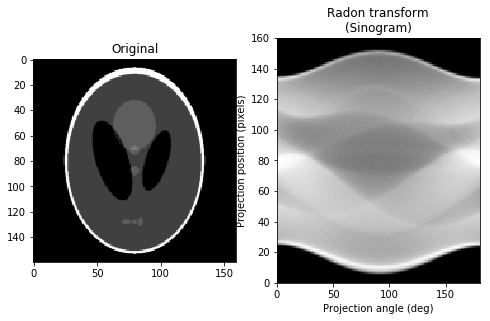

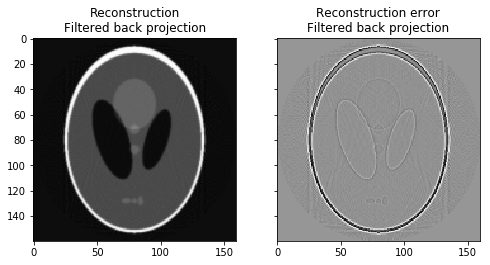

In [15]:
#to samo przy użyciu gotowej biblioteki skimage
from skimage.transform import iradon

image = imread(data_dir + "/phantom.png", as_gray=True)
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')


reconstruction_fbp = iradon(sinogram, theta=theta, circle=True)
error = reconstruction_fbp - image
print('FBP rms reconstruction error: %.3g' % np.sqrt(np.mean(error**2)))

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5),
                               sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

fig.tight_layout()
plt.show()